## Summarizing results

We are trying a lot of different things. Let's log the attempts to share with others

The scripts here will NOT work. We are just keeping track of what we are trying and what is different.

### Modules

In [3]:
import pandas as pd
import glob,os
import IPython.display as dp

### Kappa limits

Just realized my simulated data has catch trials generating negative kappa values ... I redesigned the simulated data to correct for this

In [4]:
kappa_bounds = 'simul/kappa_limits.csv'
df = pd.read_csv(kappa_bounds)
df

,Unnamed: 0,kappa,log_kappa,cdd_immed_amt,cdd_immed_wait,cdd_delay_amt,cdd_delay_wait
0,7,-0.325000,NaN,20,0,7,2
1,0,-0.150000,NaN,10,0,7,2
2,8,-0.150000,NaN,20,0,14,2
3,21,-0.092857,NaN,20,0,7,7
4,35,-0.043333,NaN,20,0,7,15
...,...,...,...,...,...,...,...
107,3,1.000000,0.000000,10,0,30,2
108,13,1.125000,0.117783,20,0,65,2
109,4,1.550000,0.438255,10,0,41,2
110,5,2.000000,0.693147,10,0,50,2


### Parameter recovery : v003

From v002, edit the following:
1. Going back to a shared hyper_SD for gamma and kappa to see if this improves recovery in the higher ends of kappa
2. 


### BHM code for v003

Here the priors are defined with the following parameters

```
def estimate_bhm(subj_id=[],design_df=[],choices=[],type='single'):

    delay_amt = design_df['cdd_delay_amt'].values
    delay_wait = design_df['cdd_delay_wait'].values
    immed_amt = design_df['cdd_immed_amt'].values
    immed_wait = design_df['cdd_immed_wait'].values
    
    # We will fit a model for each subject
    with pm.Model() as model_simple:

        # Hyperparameters for kappa and gamma
        # estimated from MLE approximations : np.exp(-3.60) = 0.0273
        mu_kappa_hyper = pm.Beta('mu_kappa_hyper',mu=np.exp(-3.60),sigma=0.01)
        # estimated from MLE approximations : gamma np.sqrt(2.30) = 1.517, kappa np.sqrt(1.71)=1.308
        sd_hyper = pm.LogNormal('sd_hyper',sigma=1)

        kappa = pm.LogNormal('kappa',mu=mu_kappa_hyper,sigma=sd_hyper,shape=np.size(np.unique(subj_id)))
        gamma = pm.HalfNormal('gamma',sigma=sd_hyper,shape=np.size(np.unique(subj_id)))
        
        prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma[subj_id] * ( delay_amt/(1+(kappa[subj_id]*delay_wait)) 
                                                                                - immed_amt/(1+(kappa[subj_id]*immed_wait)) ))))

        y_1 = pm.Bernoulli('y_1',p=prob,observed=choices)

        trace_prior = pm.sample(10000, tune=1000, cores=5,target_accept=0.99,progressbar=False)

    # This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
    summary= az.summary(trace_prior,round_to=10)
    if type=='single':
        kappa_hat = summary['mean'].loc['kappa[{}]'.format(0)]
        gamma_hat = summary['mean'].loc['gamma[{}]'.format(0)]
    elif type=='aggregate':
        kappa_hat = [summary['mean'].loc['kappa[{}]'.format(x)] for x in set(subj_id)]
        gamma_hat = [summary['mean'].loc['gamma[{}]'.format(x)] for x in set(subj_id)]
    return kappa_hat,gamma_hat
```

### Parameter recovery : v002

Tried changing two things from v001:
1. Tried loosening the variance on the SD_hyper for kappa and gamma from 0.1 to 0.5, with the following constraint
2. Loosening the variance, ran the risk of sampling a negative value for the SD, so we added a bound at 0.05 with a [`TruncatedNormal()`](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.TruncatedNormal.html).


### BHM code for v002

Here the priors are defined with the following parameters

```
def estimate_bhm(subj_id=[],design_df=[],choices=[],type='single'):

    delay_amt = design_df['cdd_delay_amt'].values
    delay_wait = design_df['cdd_delay_wait'].values
    immed_amt = design_df['cdd_immed_amt'].values
    immed_wait = design_df['cdd_immed_wait'].values
    
    # We will fit a model for each subject
    with pm.Model() as model_simple:

        # Hyperparameters for kappa and gamma
        # estimated from MLE approximations : np.exp(-3.60) = 0.0273, np.sqrt(1.71)=1.308
        mu_kappa_hyper = pm.Beta('mu_kappa_hyper',mu=np.exp(-3.60),sigma=0.1)
        sd_kappa_hyper = pm.TruncatedNormal('sd_kappa_hyper',mu=np.sqrt(1.71),sigma=0.5,lower=0.05)
        # estimated from MLE approximations : np.sqrt(2.30) = 1.517
        sd_gamma_hyper = pm.TruncatedNormal('sd_gamma_hyper',mu=np.sqrt(2.30),sigma=0.5,lower=0.05)

        kappa = pm.LogNormal('kappa',mu=mu_kappa_hyper,sigma=sd_kappa_hyper,shape=np.size(np.unique(subj_id)))
        gamma = pm.HalfNormal('gamma',sigma=sd_gamma_hyper,shape=np.size(np.unique(subj_id)))
        
        prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma[subj_id] * ( delay_amt/(1+(kappa[subj_id]*delay_wait)) 
                                                                                - immed_amt/(1+(kappa[subj_id]*immed_wait)) ))))

        y_1 = pm.Bernoulli('y_1',p=prob,observed=choices)

        trace_prior = pm.sample(10000, tune=1000, cores=5,target_accept=0.99,progressbar=False)

    # This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
    summary= az.summary(trace_prior,round_to=10)
    if type=='single':
        kappa_hat = summary['mean'].loc['kappa[{}]'.format(0)]
        gamma_hat = summary['mean'].loc['gamma[{}]'.format(0)]
    elif type=='aggregate':
        kappa_hat = [summary['mean'].loc['kappa[{}]'.format(x)] for x in set(subj_id)]
        gamma_hat = [summary['mean'].loc['gamma[{}]'.format(x)] for x in set(subj_id)]
    return kappa_hat,gamma_hat
```

<img src="simul/img/v002/scatter/kappa_bhm_agg.png" width="800">
<img src="simul/img/v002/nmse/kappa_bhm_agg.png" width="800">
<img src="simul/img/v002/nmse/gamma_bhm_agg.png" width="800">

### Parameter recovery : v001

After Silvia discussion and the CASANDRE meeting, we used the results of the MLE on the IDM dataset to come up with a prior and ranges for the simulated data. We computed the mean and variance of the distributions of the MLE estimates (plotted below, split_CDD_analysis) as follows:

```
gamma (mean,var):(0.85,2.30)
log_kappa (mean,var):(-3.60,1.71)
```
**Note that for $\log(\kappa)$, we filtered the minimum value to compute the mean and variance above. This is a bound effect of the MLE.** Based on the MLE estimates plotted below as $\log(\kappa)$ versus $\gamma$ we did the following:

- used a `HalfNormal` for $\gamma$ with distribution estimates (mean and variance) above
- used a `LogNormal` for $\log(\kappa)$ with distribution estimates (mean and variance) above
- simulated new data in the ranges $\gamma: [0.5,2.0]$ and $\log(\kappa): [-7,2.0]$. We used the PlosOne results to refine the ranges for the simulated data for $\log(\kappa)$. 


<img src="img/mturk_all_CDD_kappa_gamma_scatter.png" width="400">
<img src="img/plosone_risk_discount.png" width="400">



1. Simulated $10\times 10$ data with $\gamma: [0.5,2.0]$ and $\log(\kappa): [-7,2.0]$
2. Ran BHM (v001 detailed below) and MLE to estimate parameters. **BHM was run as an aggregate (agg)(with hierarchy) and single (sing, individually/independently) by estimating each parameter pair from the simualted data.** 
3. Plotted heatmaps of the errors: MSE and percent error (NMSE). **The percent error was computed as normalizing MSE to the square of the ground truth.**
4. Generated scatter plots of the estimated parameter by MLE and BHM (agg and sing) versus the ground truth.
5. (**new**) Generated scatter plots of the percent error for each of the three pairwise possibilities BHM_sing, BHM_agg, MLE

The priors are defined below 


### BHM code for v001

Here the priors are defined with the following parameters

```
def estimate_bhm(subj_id=[],design_df=[],choices=[],type='single'):

    delay_amt = design_df['cdd_delay_amt'].values
    delay_wait = design_df['cdd_delay_wait'].values
    immed_amt = design_df['cdd_immed_amt'].values
    immed_wait = design_df['cdd_immed_wait'].values
    
    # We will fit a model for each subject
    with pm.Model() as model_simple:

        # Hyperparameters for kappa and gamma
        # estimated from MLE approximations : np.exp(-3.60) = 0.0273, np.sqrt(1.71)=1.308
        mu_kappa_hyper = pm.Beta('mu_kappa_hyper',mu=np.exp(-3.60),sigma=0.01)
        sd_kappa_hyper = pm.Normal('sd_kappa_hyper',mu=np.sqrt(1.71),sigma=0.1)
        # estimated from MLE approximations : np.sqrt(2.30) = 1.517
        sd_gamma_hyper = pm.Normal('sd_hyper',mu=np.sqrt(2.30),sigma=0.1)

        kappa = pm.LogNormal('kappa',mu=mu_kappa_hyper,sigma=sd_kappa_hyper,shape=np.size(np.unique(subj_id)))
        gamma = pm.HalfNormal('gamma',sigma=sd_gamma_hyper,shape=np.size(np.unique(subj_id)))
        
        prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma[subj_id] * ( delay_amt/(1+(kappa[subj_id]*delay_wait)) 
                                                                                - immed_amt/(1+(kappa[subj_id]*immed_wait)) ))))

        y_1 = pm.Bernoulli('y_1',p=prob,observed=choices)

        trace_prior = pm.sample(10000, tune=1000, cores=5,target_accept=0.99,progressbar=False)

    # This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
    summary= az.summary(trace_prior,round_to=10)
    if type=='single':
        kappa_hat = summary['mean'].loc['kappa[{}]'.format(0)]
        gamma_hat = summary['mean'].loc['gamma[{}]'.format(0)]
    elif type=='aggregate':
        kappa_hat = [summary['mean'].loc['kappa[{}]'.format(x)] for x in set(subj_id)]
        gamma_hat = [summary['mean'].loc['gamma[{}]'.format(x)] for x in set(subj_id)]
    return kappa_hat,gamma_hat
```

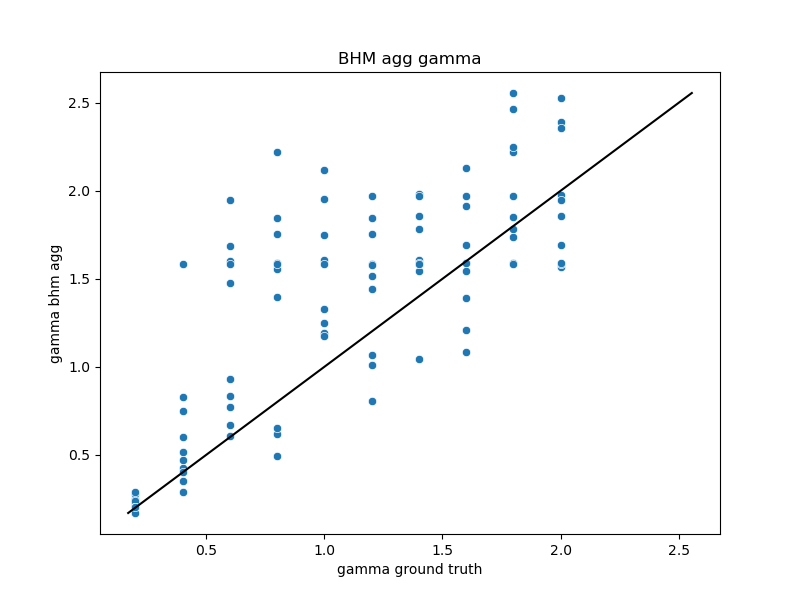

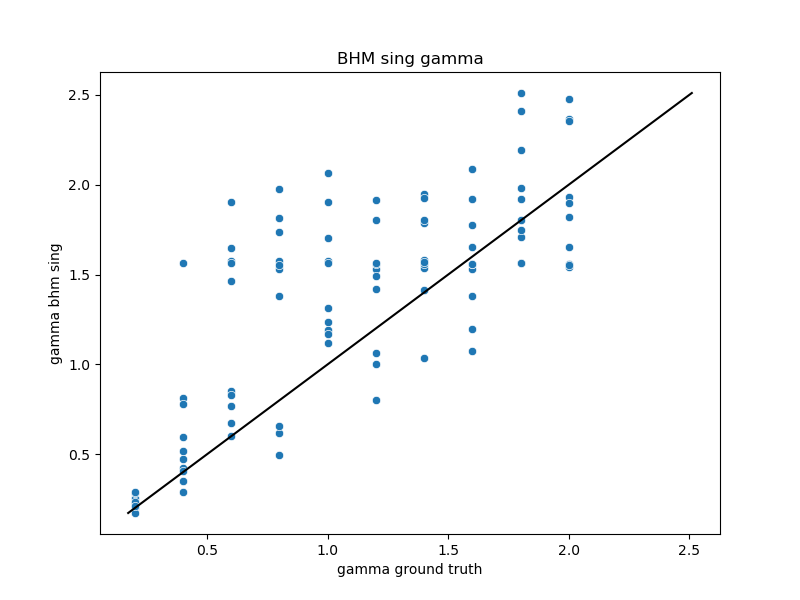

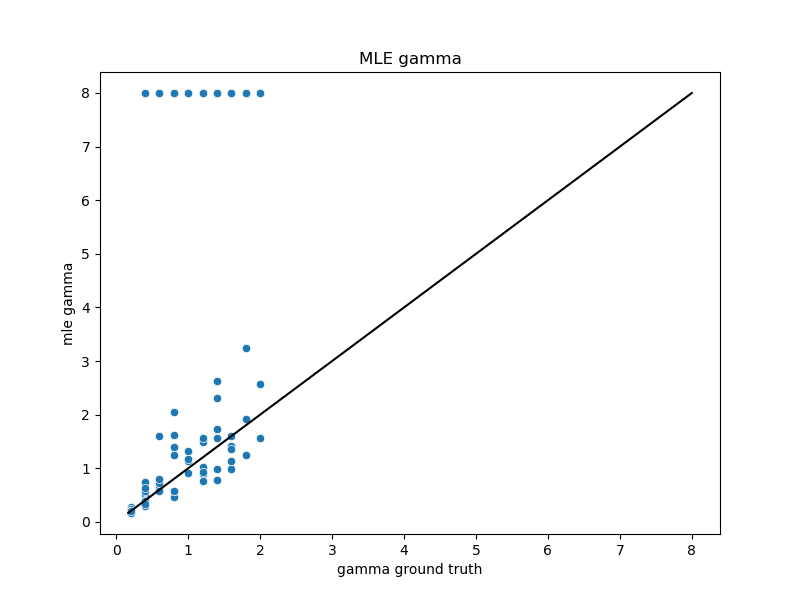

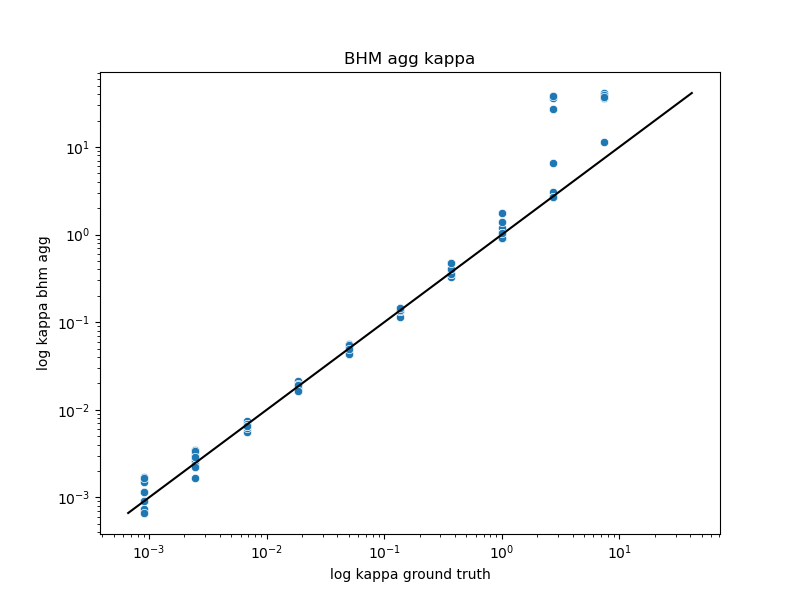

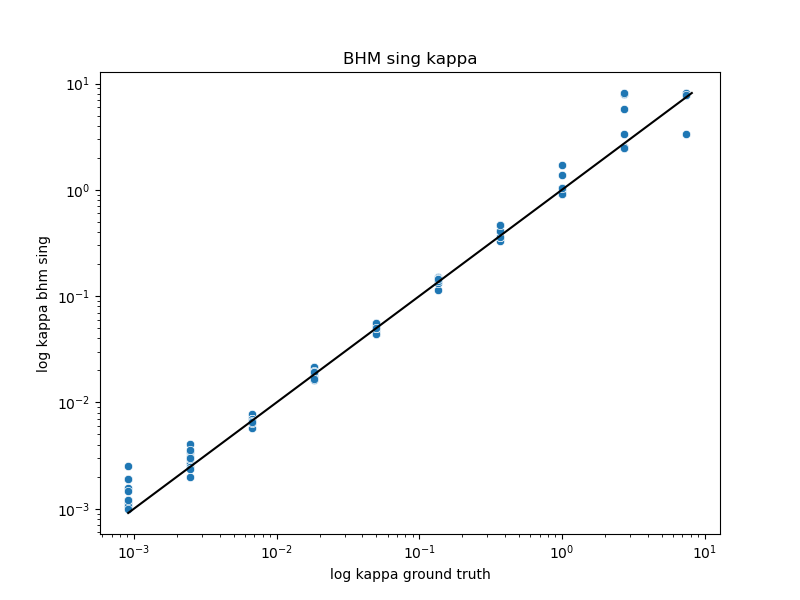

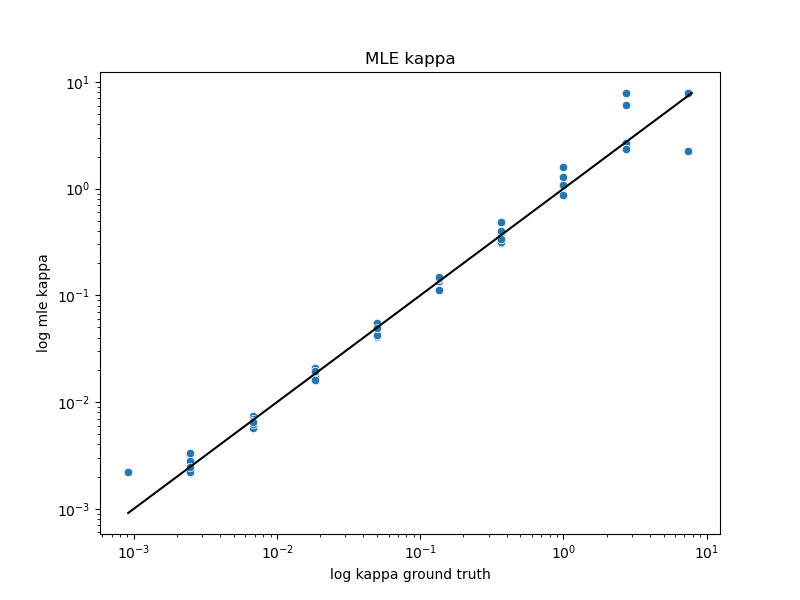

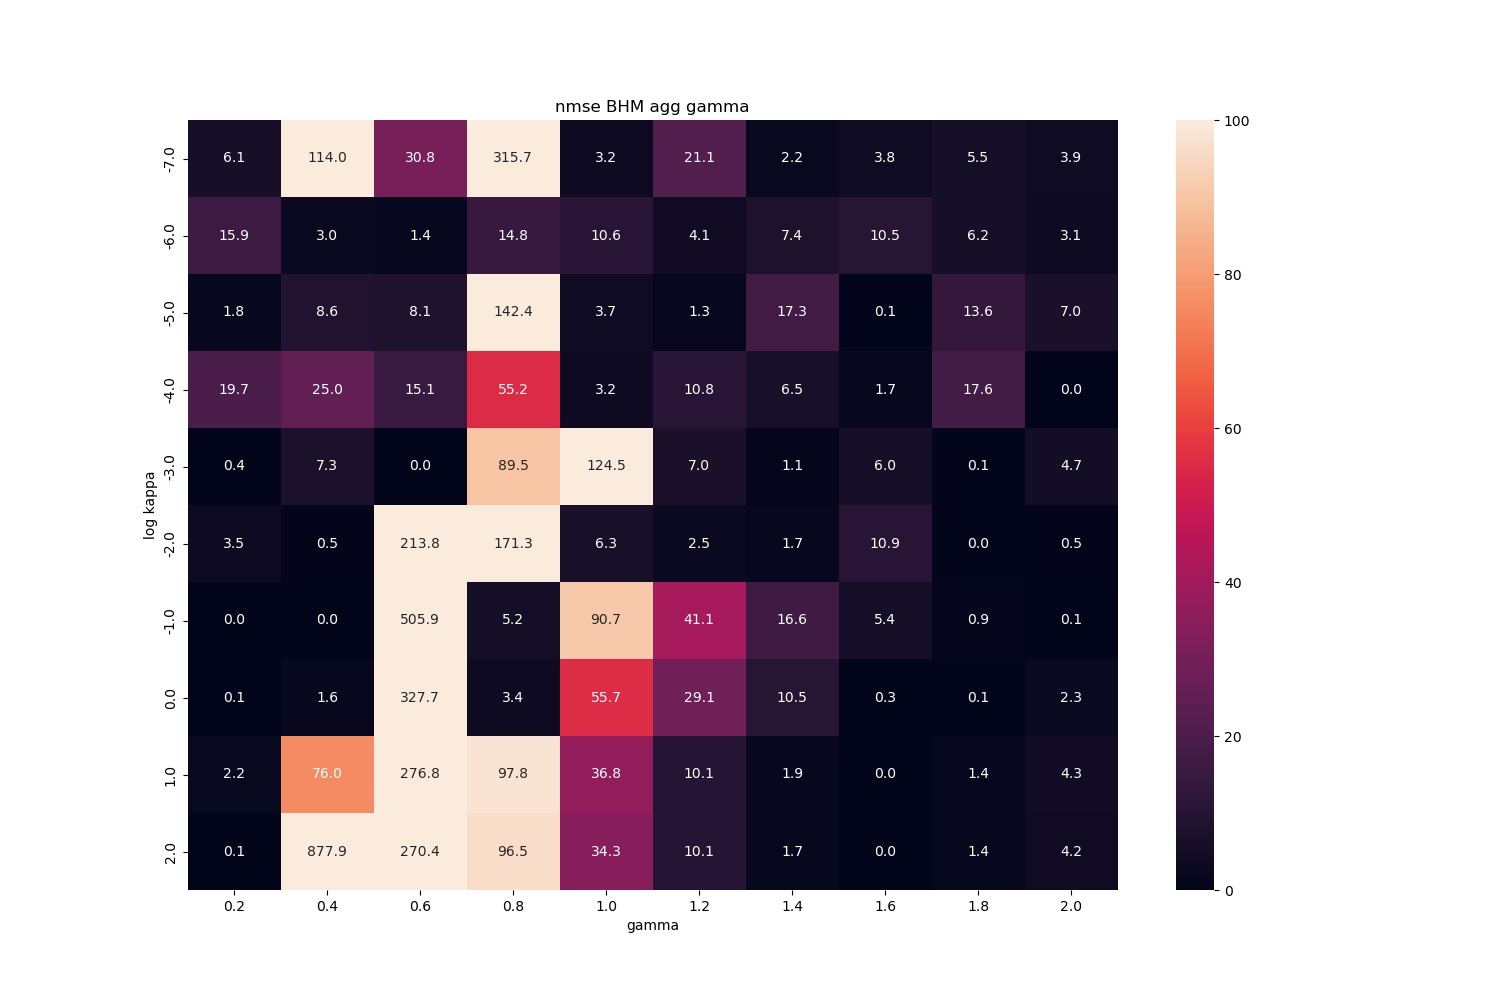

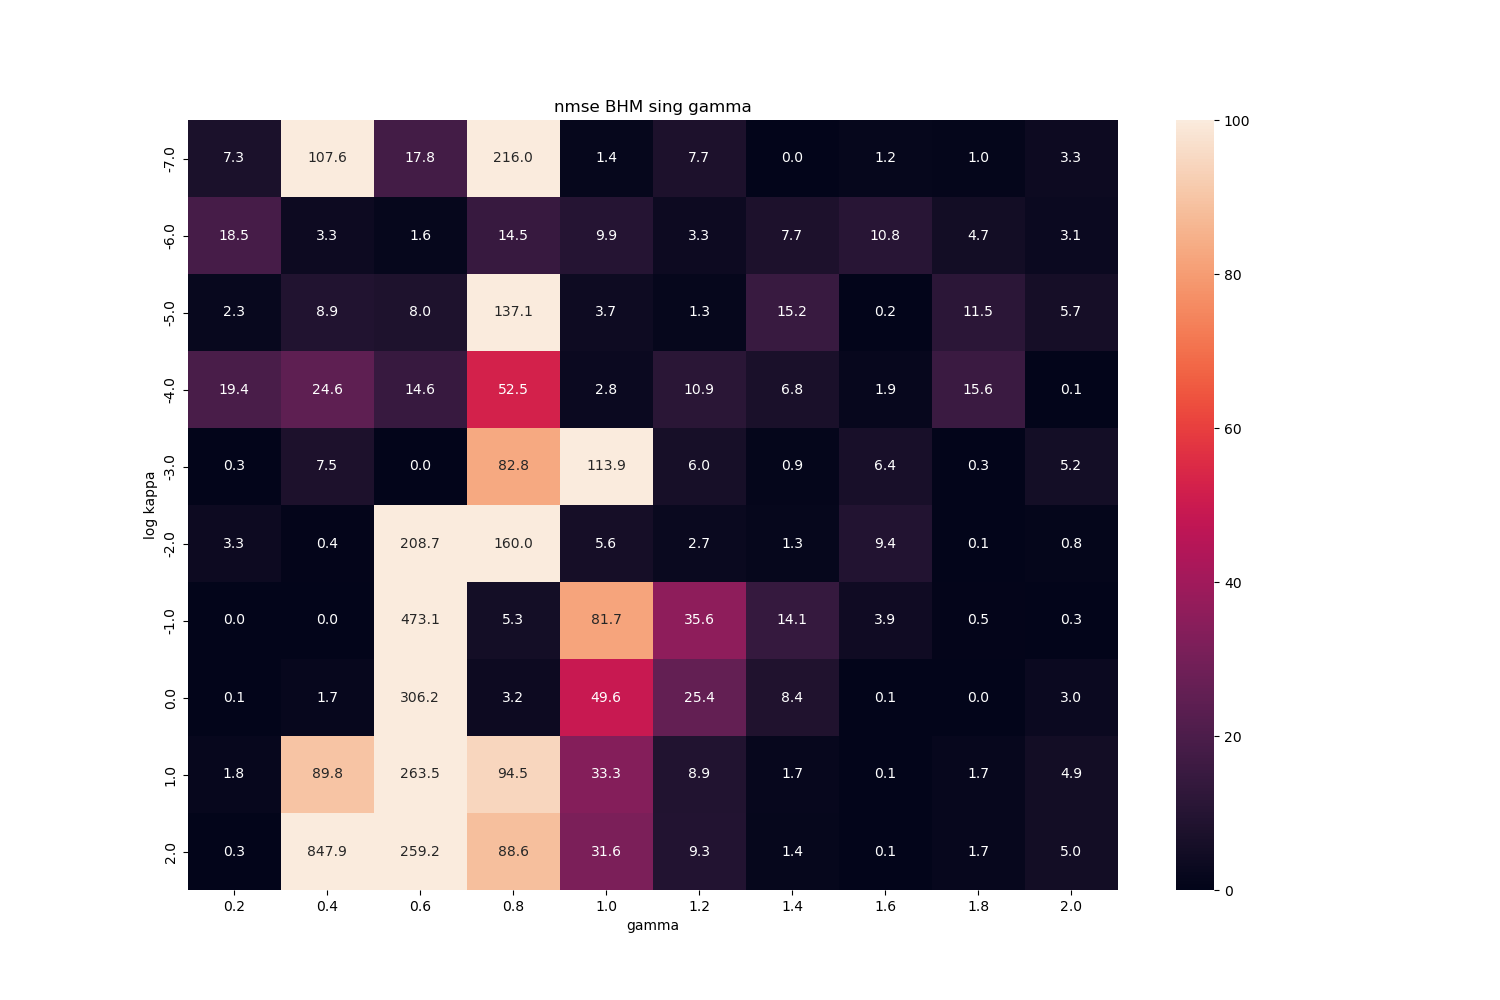

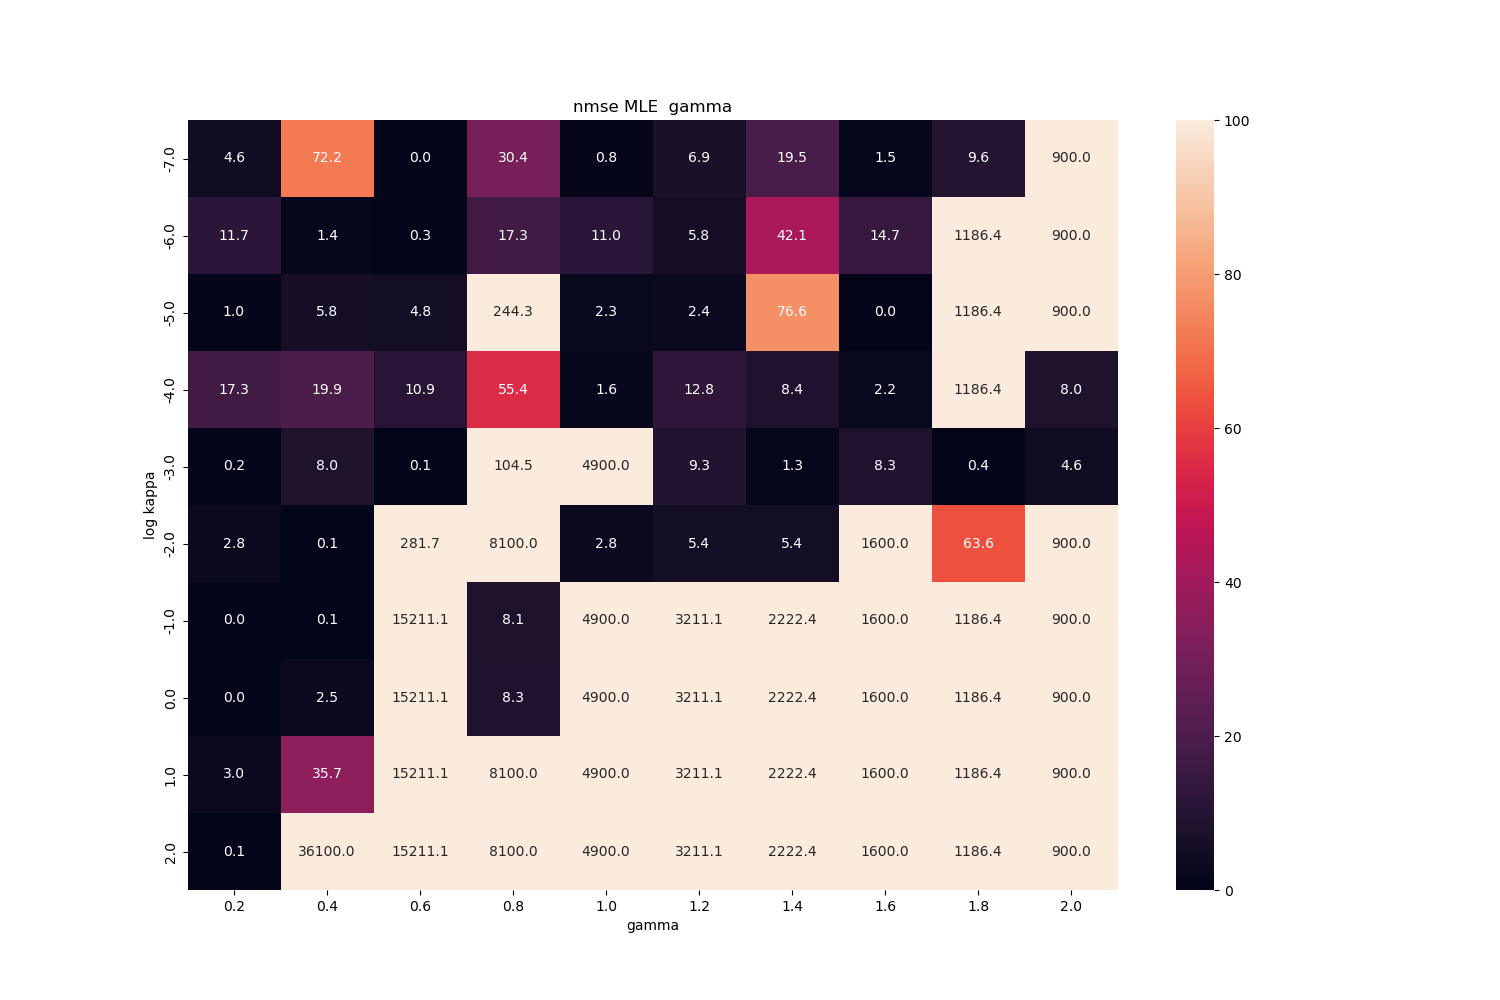

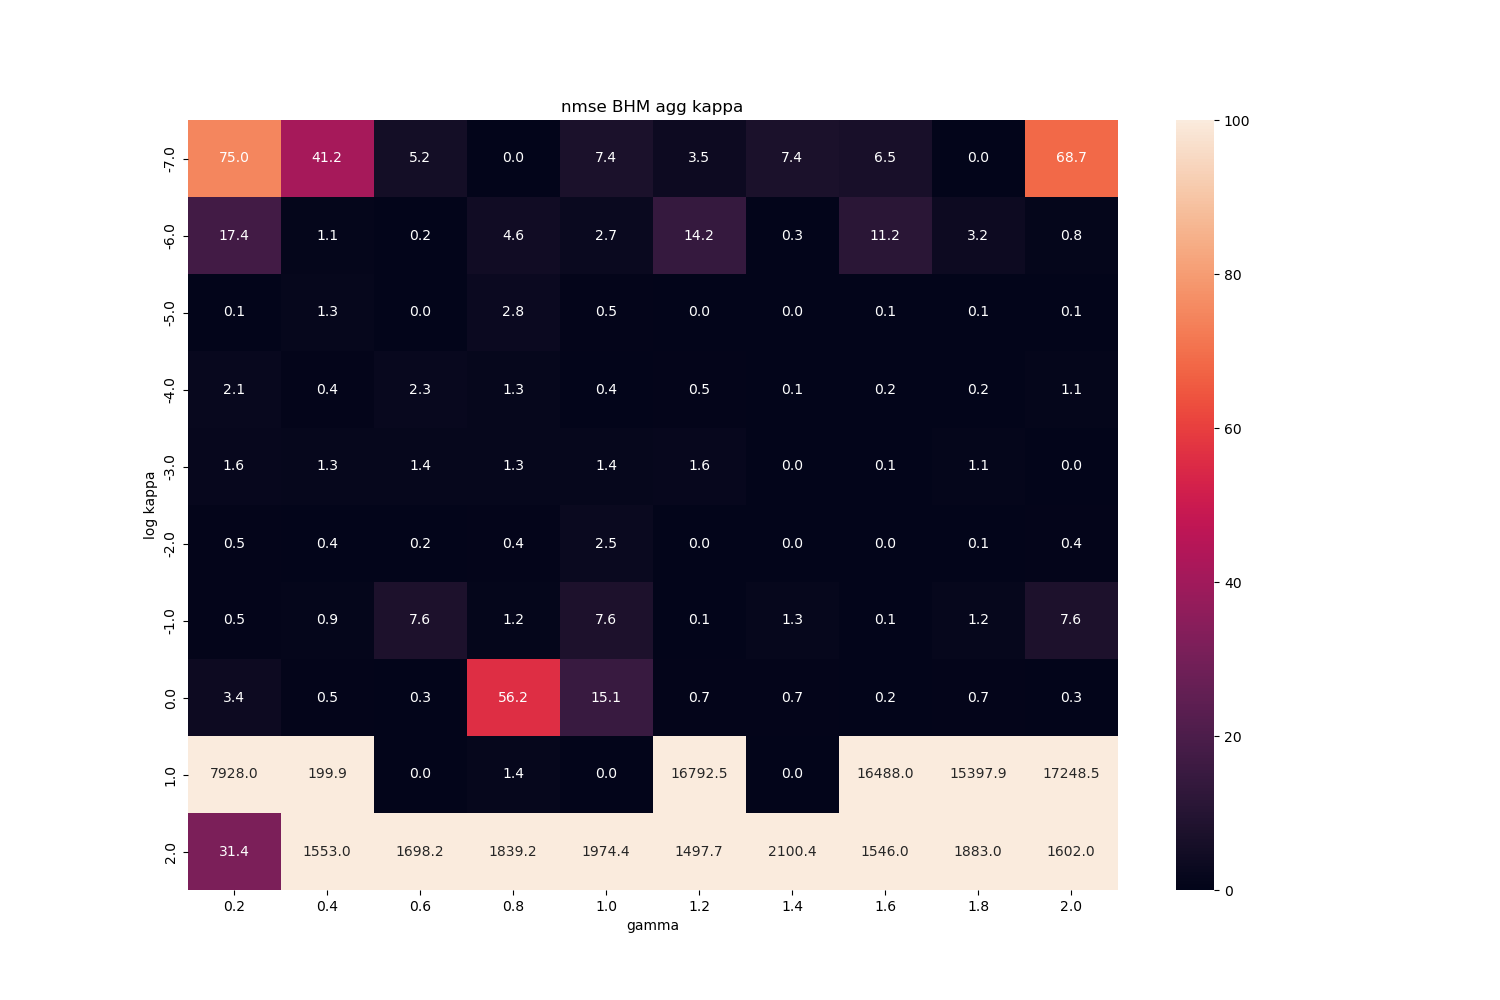

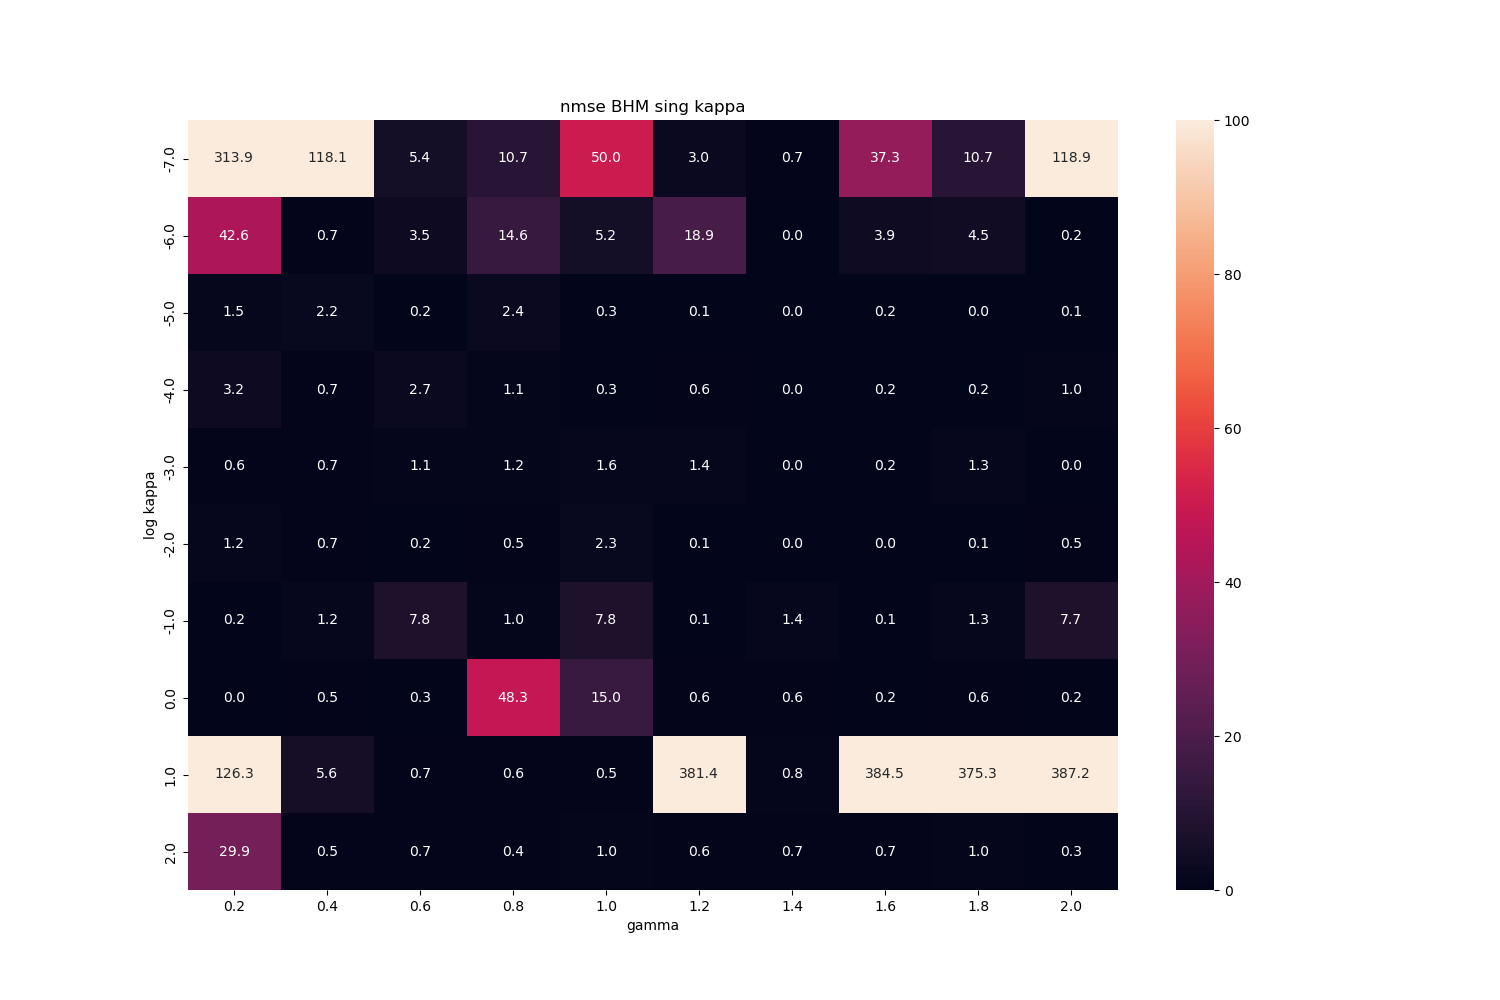

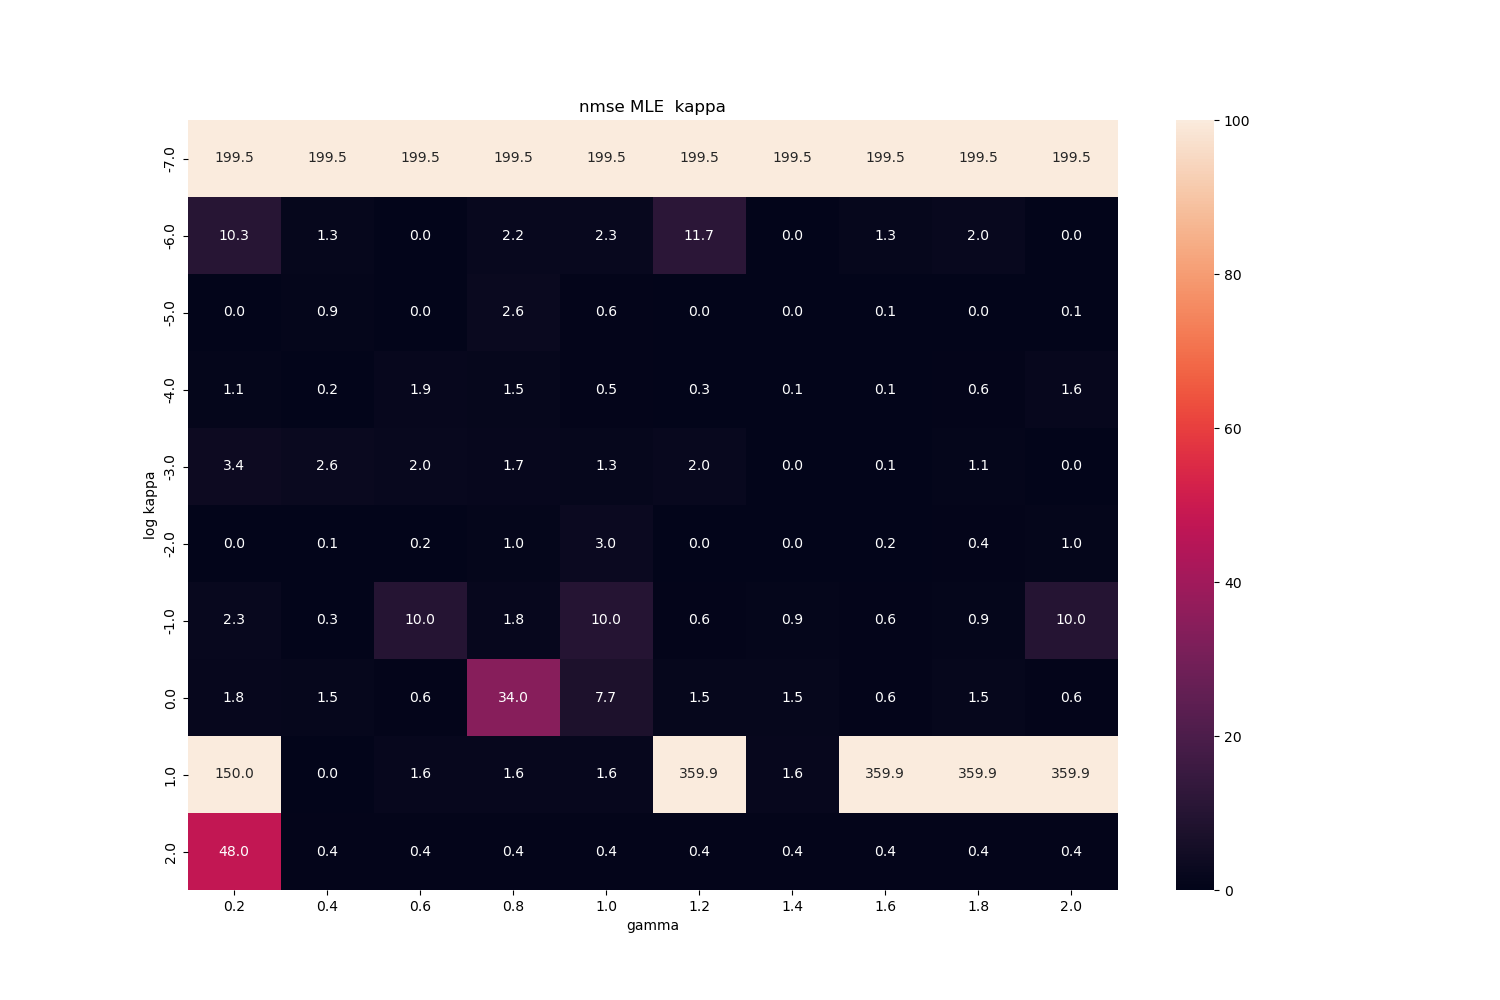

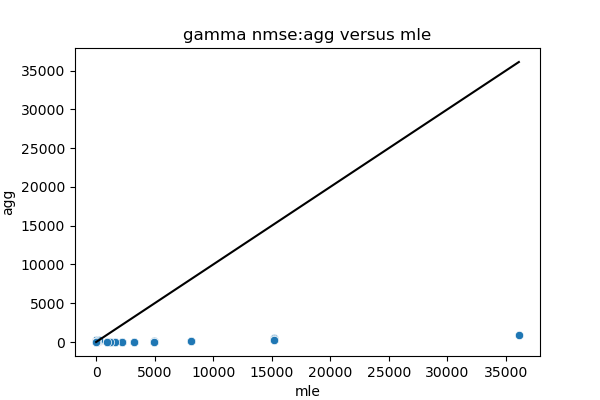

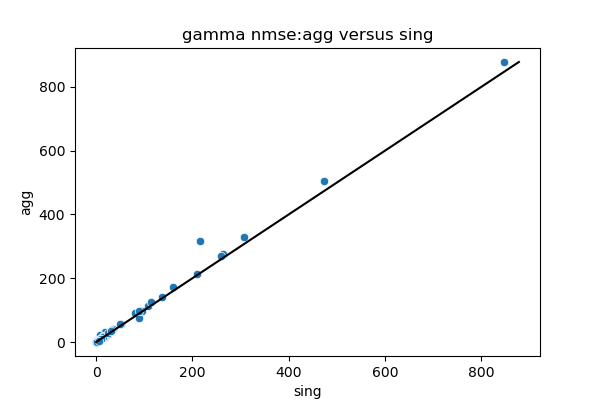

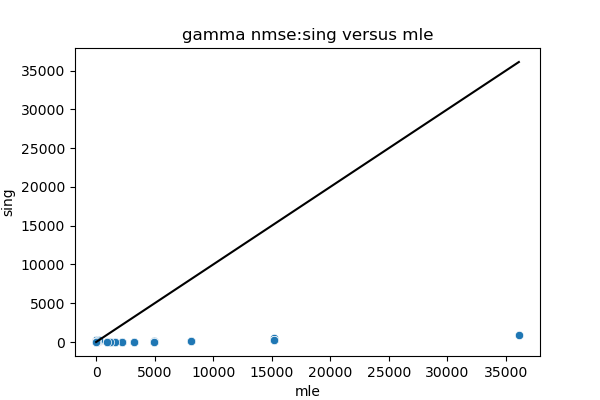

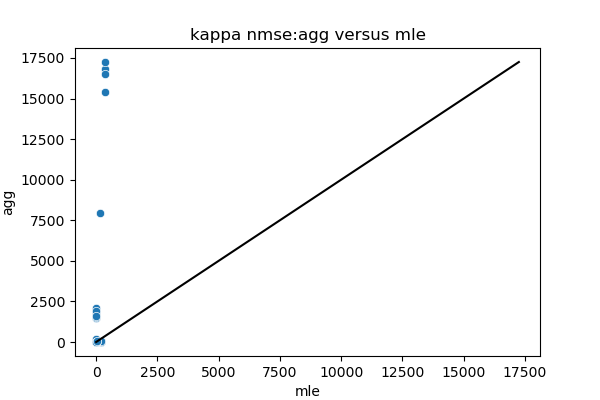

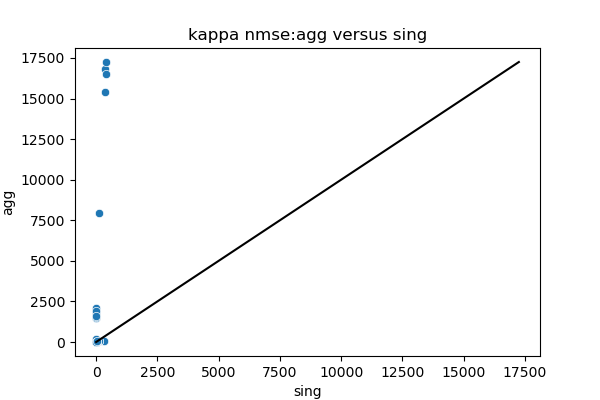

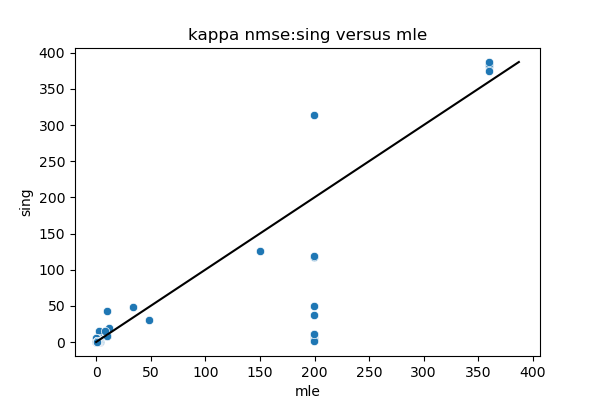

In [1]:
plots = ['scatter','nmse','vs']
for p in plots:
    file_names = sorted(glob.glob(os.path.join('simul/img/v001/{}/*.png'.format(p))))
    # collect all .png files in working dir

    # create list of image objects
    images = []
    for ea in file_names:
        images.append(dp.Image(filename=ea, format='png'))

    # display all images
    for ea in images:
        dp.display_png(ea)


### Parameter recovery : v000

1. Simulated  $10\times 10$ data with $\gamma: [0.5,5.0]$ and $\log(\kappa): [-11.5,0.0]$
2. Ran BHM (v000 detailed below) and MLE to estimate parameters. **BHM was run as an aggregate (agg)(with hierarchy) and single (sing, individually/independently) by estimating each parameter pair from the simualted data.** 
3. Plotted heatmaps of the errors: MSE and percent error (NMSE). **The percent error was computed as normalizing MSE to the square of the estimated parameters.**
4. Generated scatter plots of the estimated parameter by MLE and BHM (agg and sing) versus the ground truth.

v000 **gHNorm_kLogNorm_shareSD** :: gamma HalfNormal, kappa LogNormal, shared LogNormal SD

- The priors are defined below but the biggest feature is sharing the hyper prior for the SD of both gamma and kappa. Intuitively this does not make sense but it was working when compared to MLE.

> I started developing BHM by estimating the parameters on the IDM dataset and comparing them to the MLE. This got me pretty far but discussing with Dr. Lopez, I realized I needed to develop BHM separately with a parameter recovery. This was a good start but now I can properly assess BHM to MLE with the parameter recovery pipeline.

<img src="img/gamma-gHNorm_kLogNorm_shareSD.png" width="400"> 
<img src="img/kappa-gHNorm_kLogNorm_shareSD.png" width="400">

### BHM code for v000

Here the priors are defined with the following parameters

```
def estimate_bhm(subj_id=[],design_df=[],choices=[],type='single'):

    delay_amt = design_df['cdd_delay_amt'].values
    delay_wait = design_df['cdd_delay_wait'].values
    immed_amt = design_df['cdd_immed_amt'].values
    immed_wait = design_df['cdd_immed_wait'].values
    
    # We will fit a model for each subject
    with pm.Model() as model_simple:

        # Hyperparameters for kappa
        mu_kappa_hyper = pm.Beta('mu_kappa_hyper',mu=0.02,sigma=0.01)
        # use the same hyper SD for both parameters
        sd_hyper = pm.LogNormal('sd_hyper',sigma=1)

        kappa = pm.LogNormal('kappa',mu=mu_kappa_hyper,sigma=sd_hyper,shape=np.size(np.unique(subj_id)))
        gamma = pm.HalfNormal('gamma',sigma=sd_hyper,shape=np.size(np.unique(subj_id)))
        
        prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma[subj_id] * ( delay_amt/(1+(kappa[subj_id]*delay_wait)) 
                                                                                - immed_amt/(1+(kappa[subj_id]*immed_wait)) ))))

        y_1 = pm.Bernoulli('y_1',p=prob,observed=choices)

        trace_prior = pm.sample(10000, tune=1000, cores=5,target_accept=0.99,progressbar=False)

    # This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
    summary= az.summary(trace_prior,round_to=10)
    if type=='single':
        kappa_hat = summary['mean'].loc['kappa[{}]'.format(0)]
        gamma_hat = summary['mean'].loc['gamma[{}]'.format(0)]
    elif type=='aggregate':
        kappa_hat = [summary['mean'].loc['kappa[{}]'.format(x)] for x in set(subj_id)]
        gamma_hat = [summary['mean'].loc['gamma[{}]'.format(x)] for x in set(subj_id)]
    return kappa_hat,gamma_hat
```


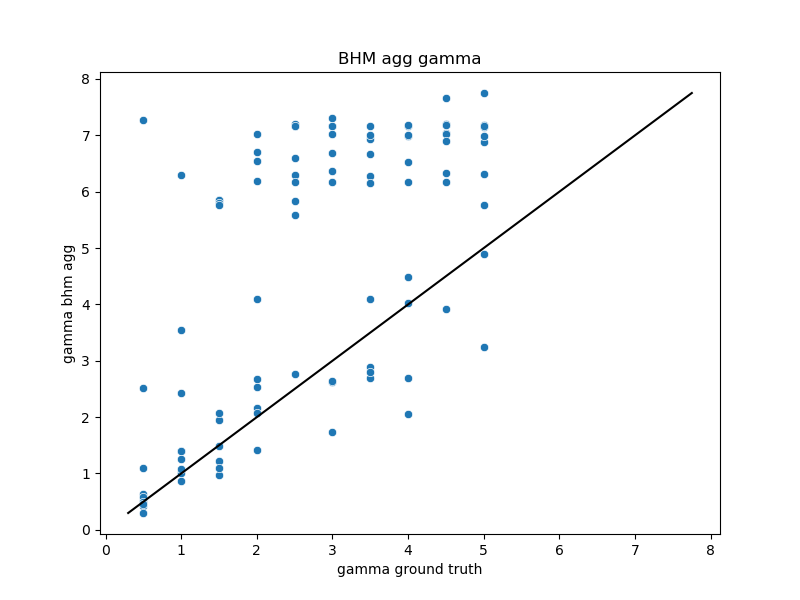

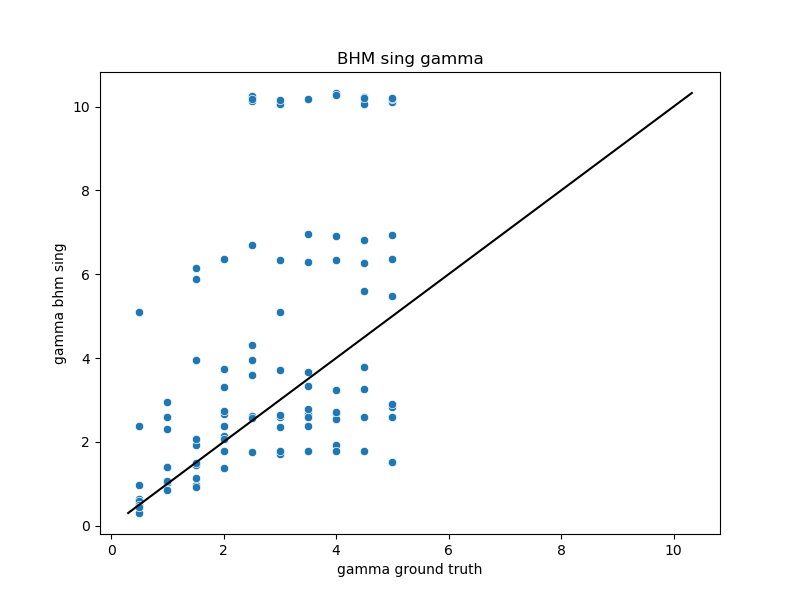

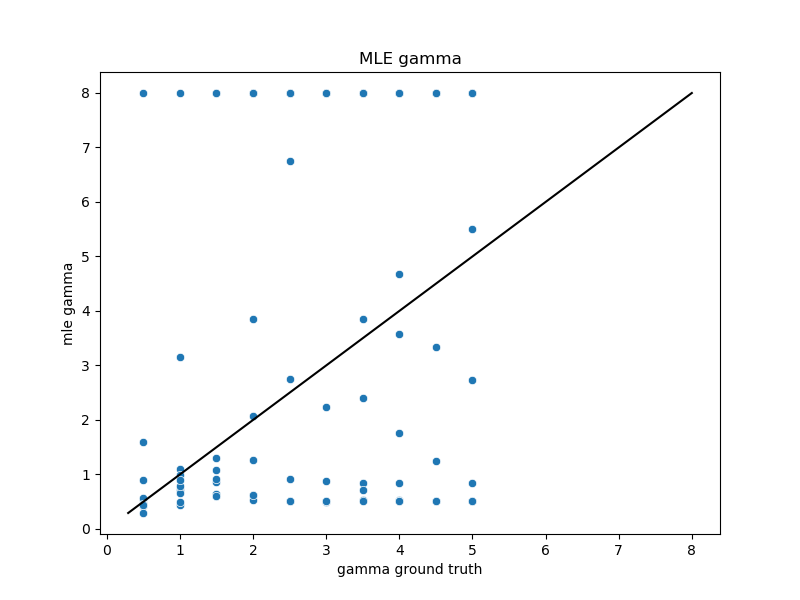

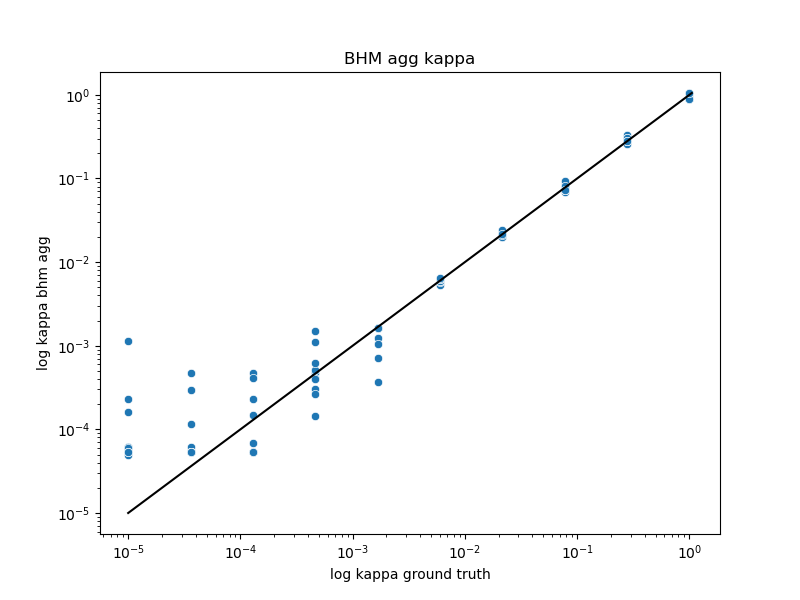

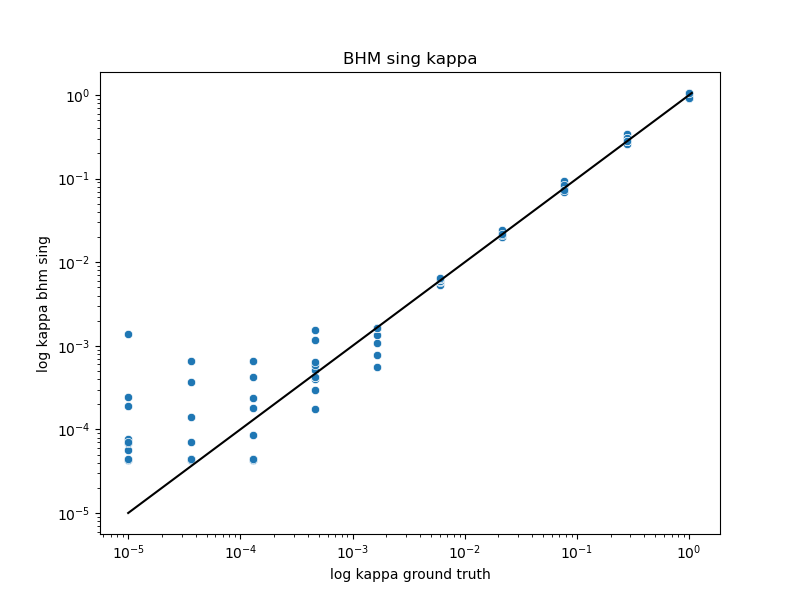

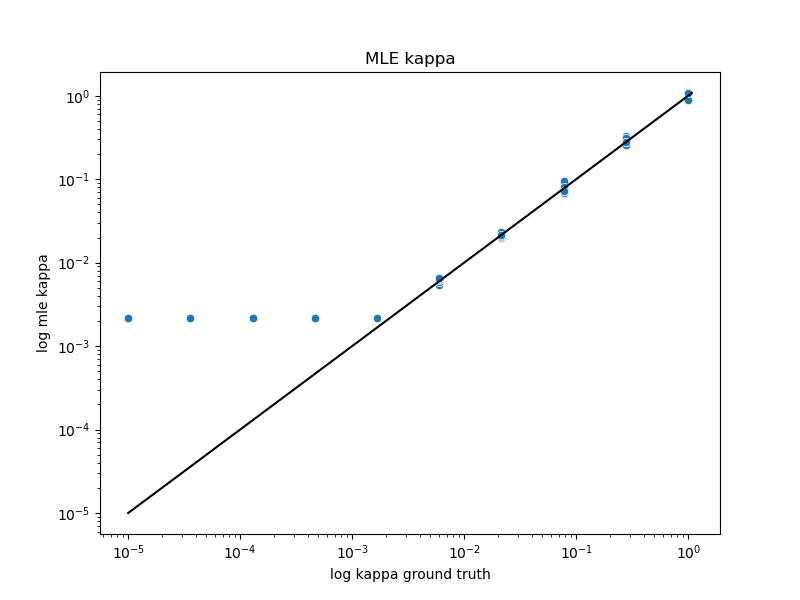

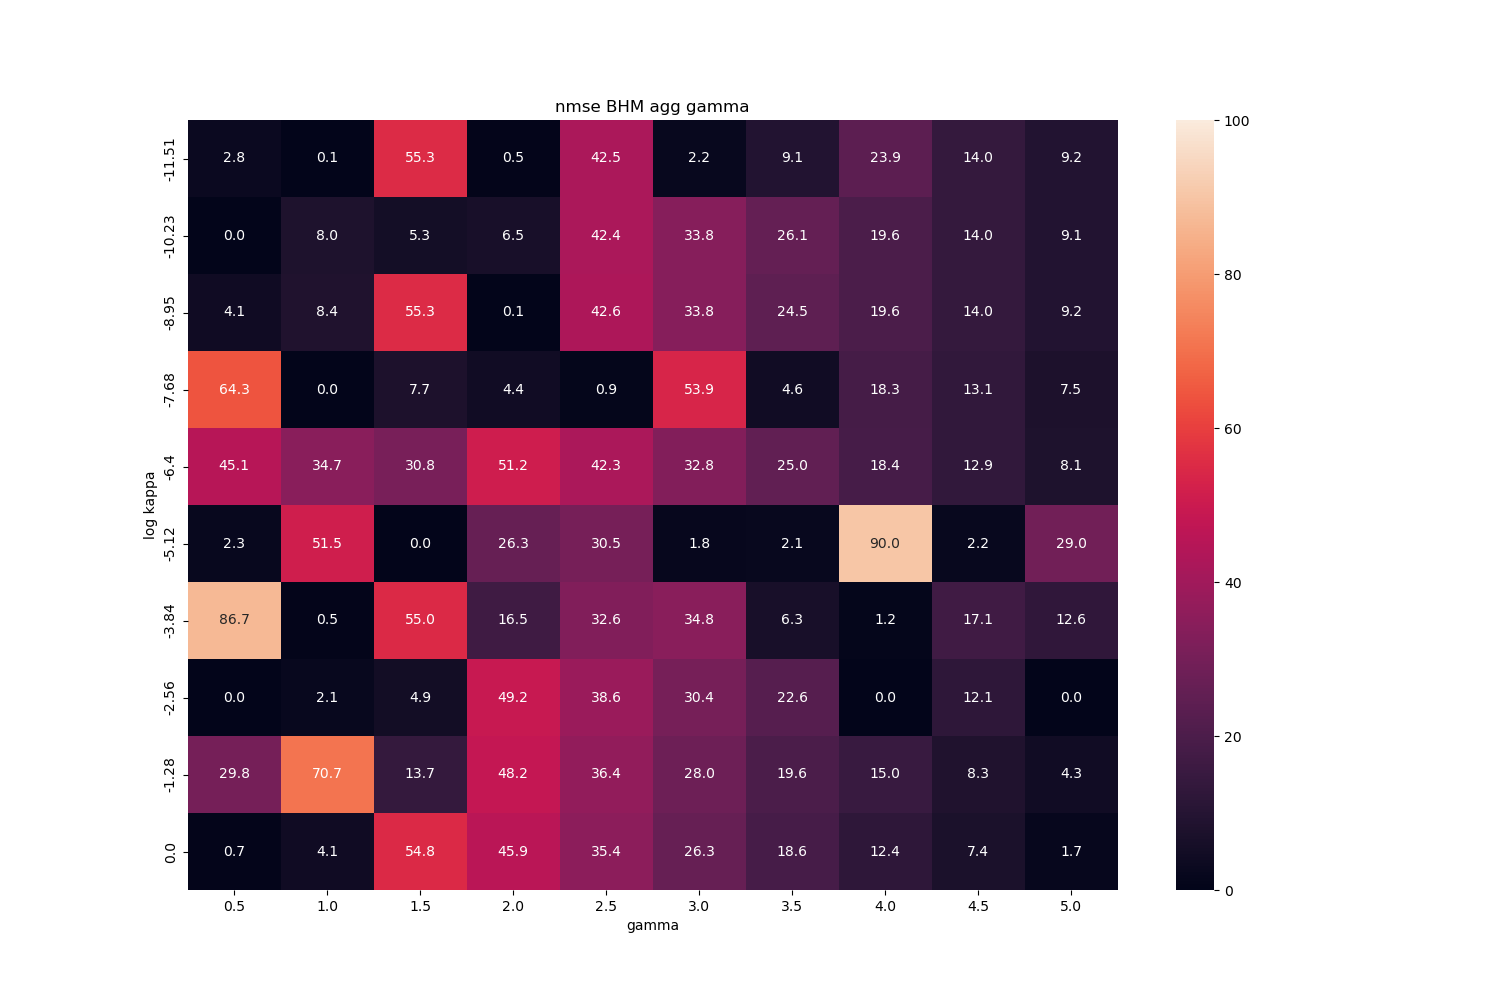

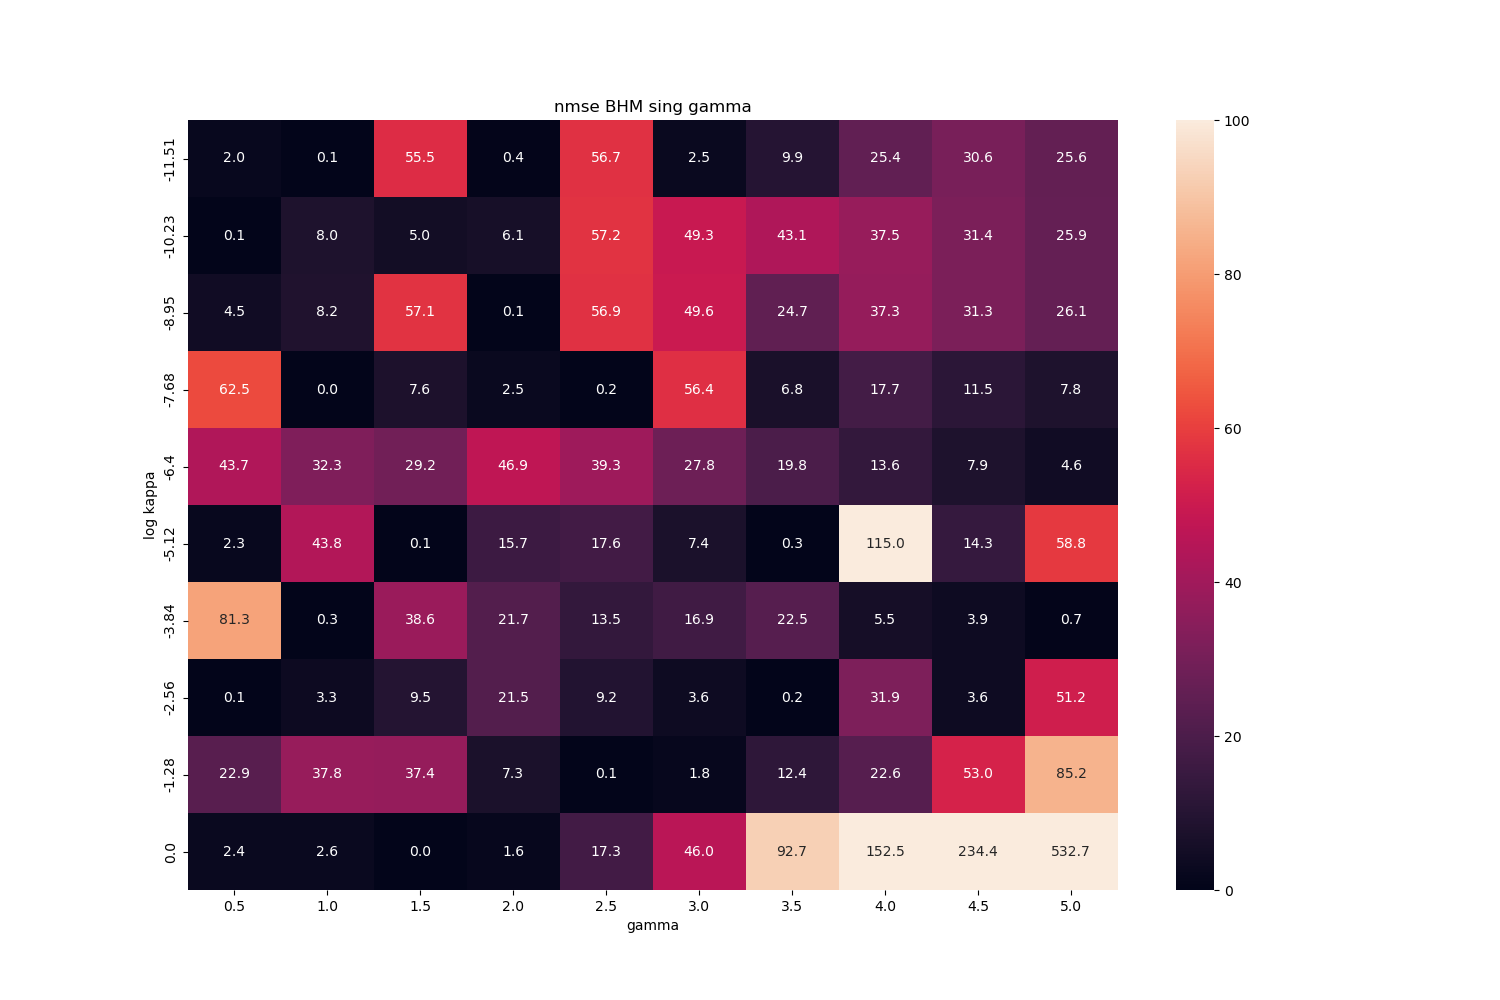

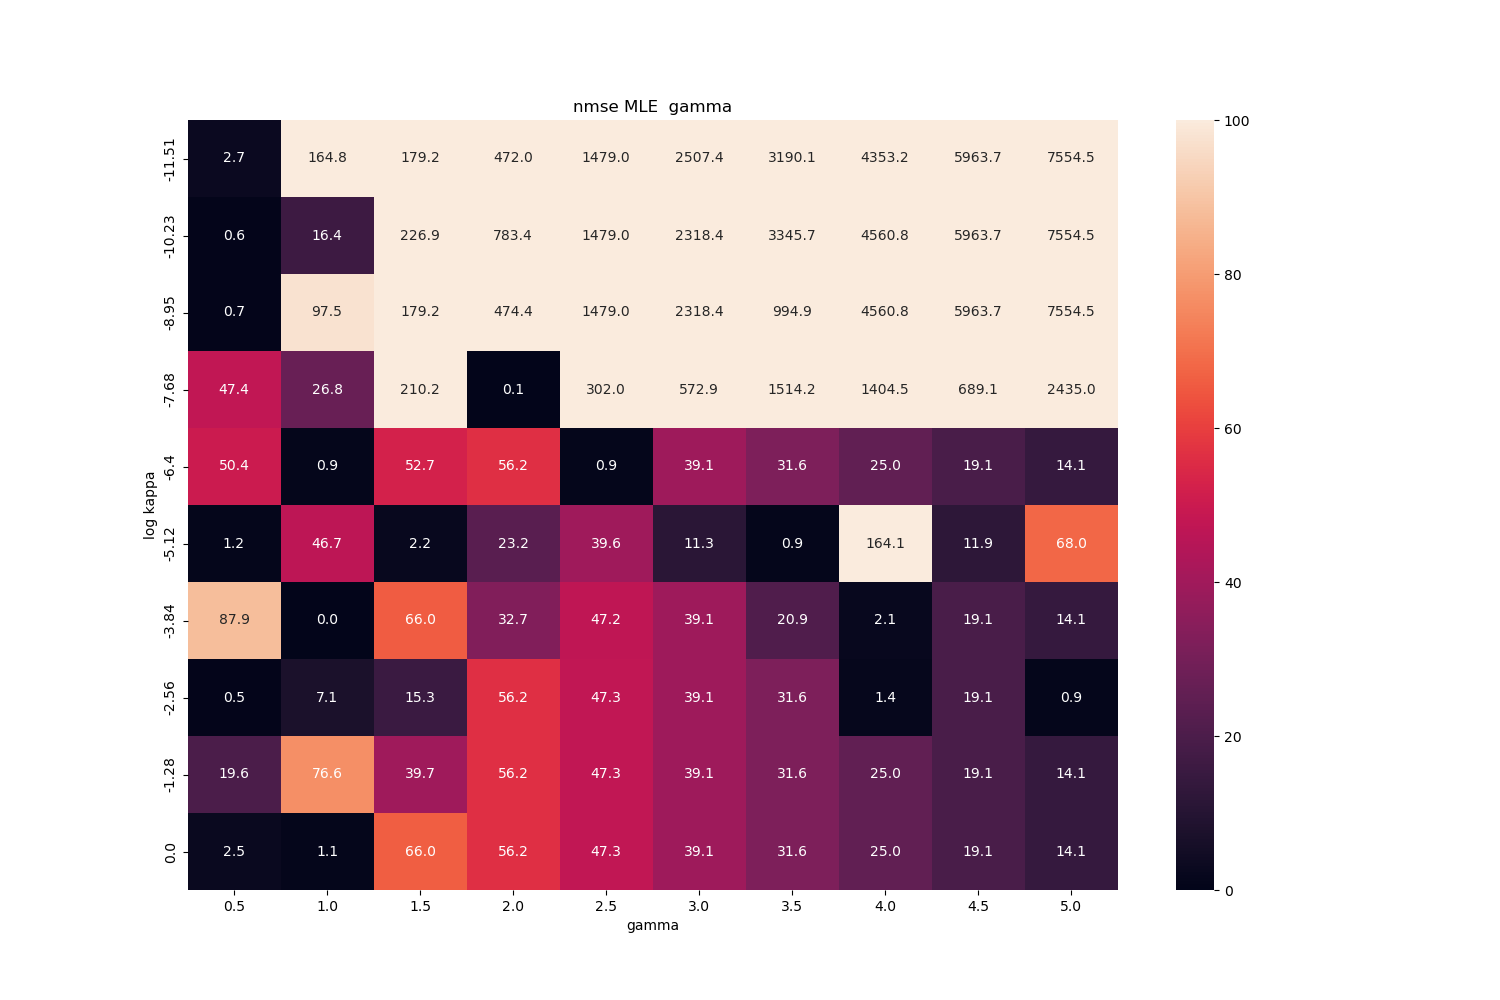

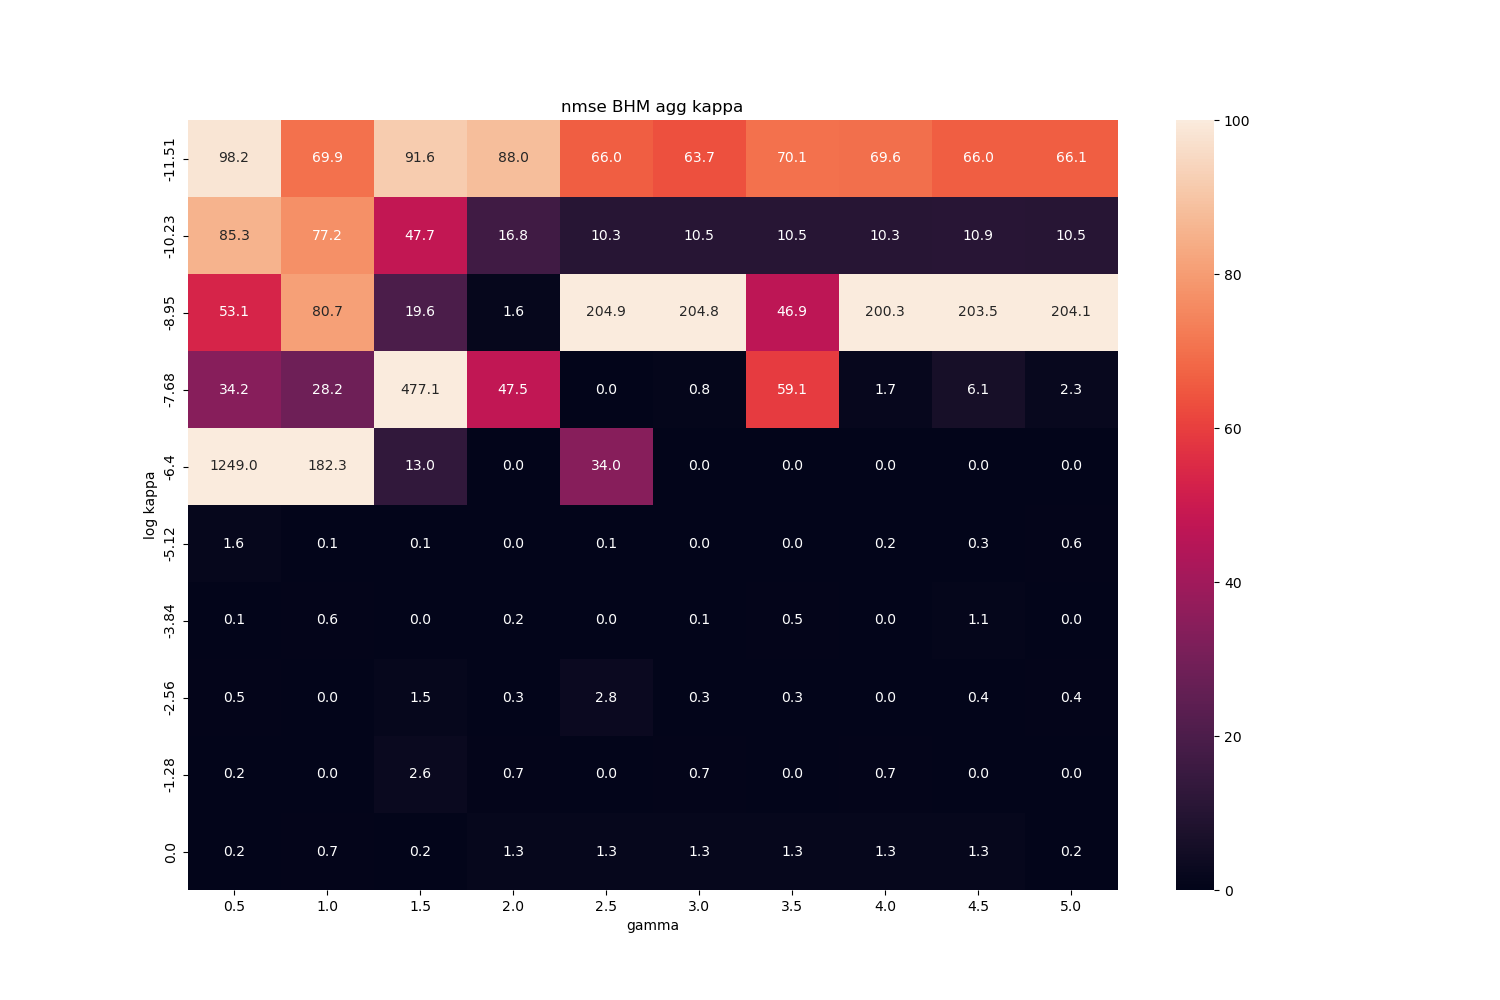

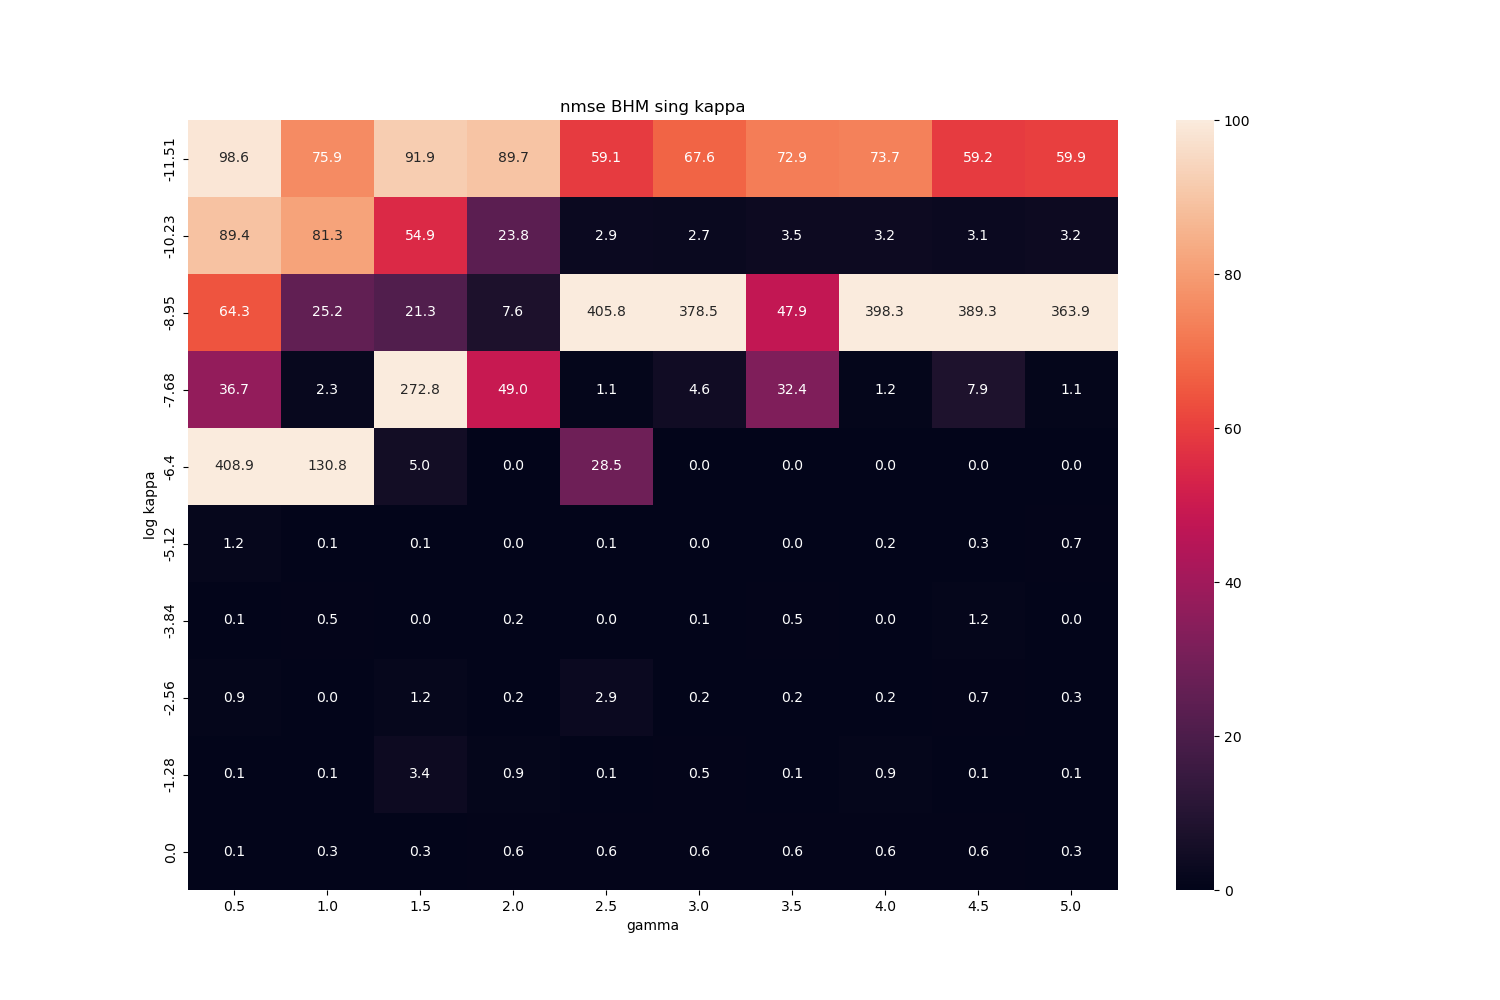

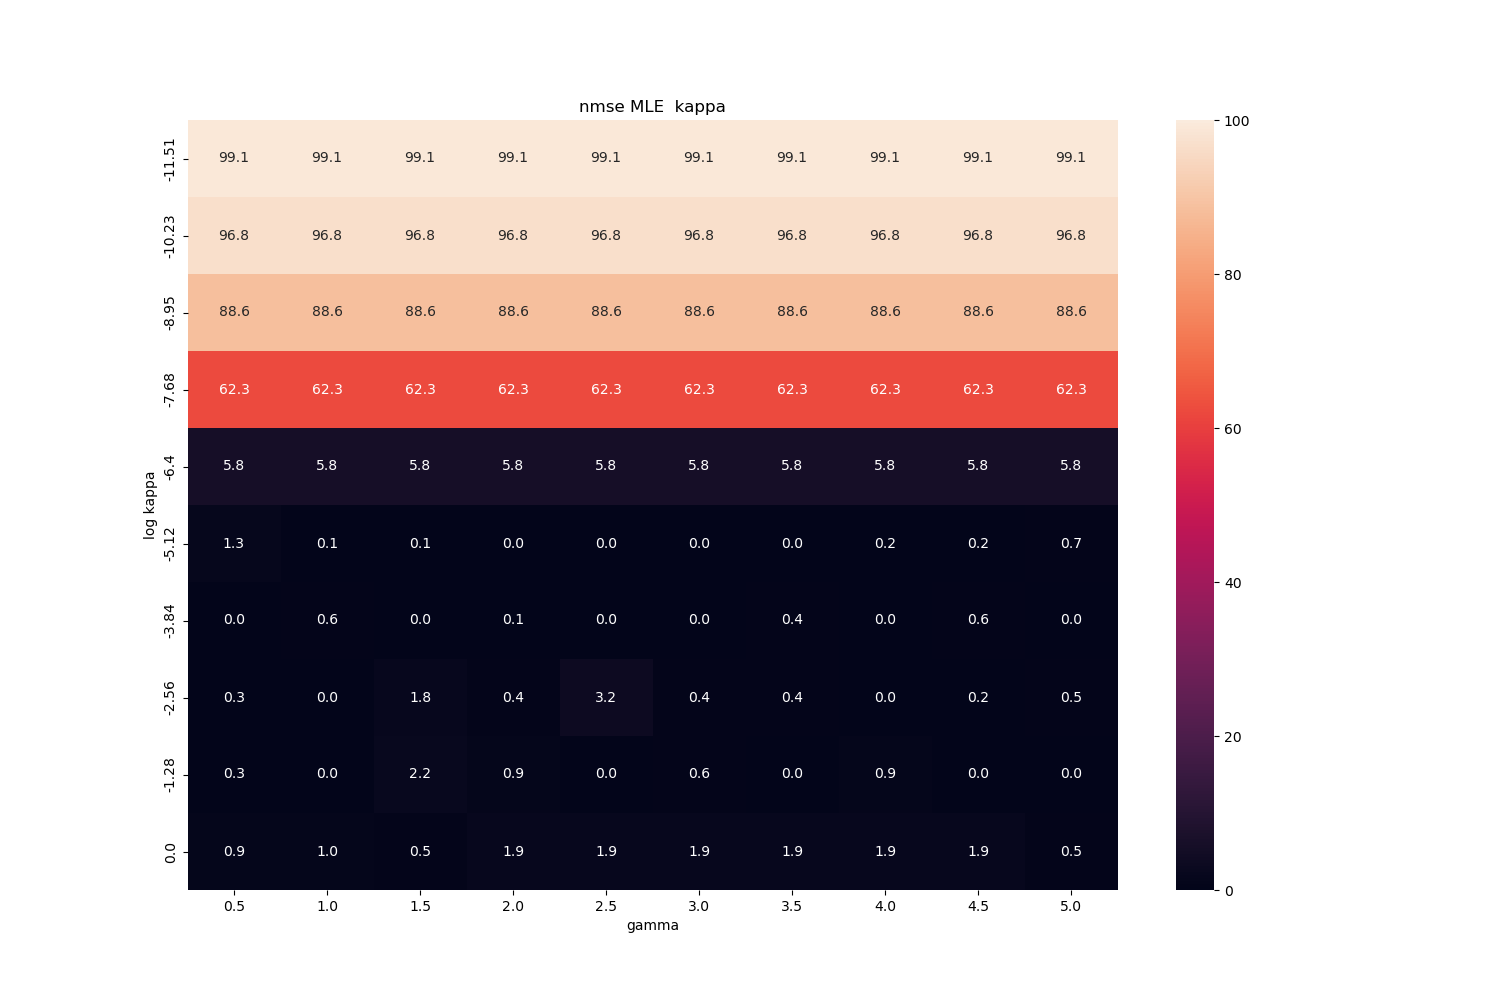

In [2]:
plots = ['scatter','nmse']
for p in plots:
    file_names = sorted(glob.glob(os.path.join('simul/img/v000/{}/*.png'.format(p))))
    # collect all .png files in working dir

    # create list of image objects
    images = []
    for ea in file_names:
        images.append(dp.Image(filename=ea, format='png'))

    # display all images
    for ea in images:
        dp.display_png(ea)
